In [1]:
# 경로에 폴더가 없으면 폴더 만들기
import os

def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [2]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
import itertools
import pathlib
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

EPOCH = 100
KERNEL_SIZE = 3
BATCH_SIZE = 128
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

DATA_PATH = "./graph_data/"

def list_to_list(input_list):
    input_list_to_list = list(itertools.chain(*input_list))
    return input_list_to_list

# 데이터 불러오기

In [3]:
data_dir = pathlib.Path(DATA_PATH)
print(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

f = list(data_dir.glob('F/*'))
n = list(data_dir.glob('N/*'))
q = list(data_dir.glob('Q/*'))
s = list(data_dir.glob('S/*'))
v = list(data_dir.glob('V/*'))

graph_data
112599


# 데이터 split
## train, test, validation data 나누기

In [4]:
parents_path = DATA_PATH

In [5]:
parents_path = DATA_PATH
child_path = os.listdir(parents_path)

npy_check_list = []

temp_converted_img = list()
temp_ann_list = list()
X = list()
y = list()

for pic_path in (child_path):
    if pic_path =="N" or pic_path =="Q":
        continue

    current_path = os.listdir(parents_path + pic_path)
    print("[INFO] Current path : " + parents_path + pic_path)
    for file_name in tqdm(current_path):
        path_for_array = parents_path + pic_path + "/" + file_name

        img = cv2.imread(path_for_array)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resize = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_AREA)
        temp_converted_img.append(img_resize / 255.0)
        
        check_ann = pic_path
        
        if check_ann == "N":            # Normal
            pass
        
        elif check_ann == "S":          # Supra-ventricular
            temp_ann_list.append([0, 1, 0, 0, 0])
        
        elif check_ann == "V":          # Ventricular
            temp_ann_list.append([0, 0, 1, 0, 0])
        
        elif check_ann == "F":          # False alarm
            temp_ann_list.append([0, 0, 0, 1, 0])
        
        else:                           # Unclassed 
            temp_ann_list.append([0, 0, 0, 0, 1])
    
        y.append(temp_ann_list)

[INFO] Current path : ./graph_data/F


100%|██████████| 803/803 [00:05<00:00, 137.29it/s]


[INFO] Current path : ./graph_data/S


100%|██████████| 2781/2781 [00:20<00:00, 135.88it/s]


[INFO] Current path : ./graph_data/V


100%|██████████| 7236/7236 [01:03<00:00, 113.26it/s]


In [6]:
onehot_y = np.array(temp_ann_list)
temp_converted_img = np.array(temp_converted_img)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(temp_converted_img, onehot_y, test_size=0.33, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True)

print("[SIZE]\t\tNpX lenght : {}\n\t\tNpY length : {}".format(X_train.shape, y_train.shape))
print("[SIZE]\t\tX_validation length : {}\n\t\ty_validation length : {}".format(X_val.shape, y_val.shape))
print("[SIZE]\t\tX_test length : {}\n\t\ty_test length : {}".format(X_test.shape, y_test.shape))

[SIZE]		NpX lenght : (7249, 128, 128)
		NpY length : (7249, 5)
[SIZE]		X_validation length : (1179, 128, 128)
		y_validation length : (1179, 5)
[SIZE]		X_test length : (2392, 128, 128)
		y_test length : (2392, 5)


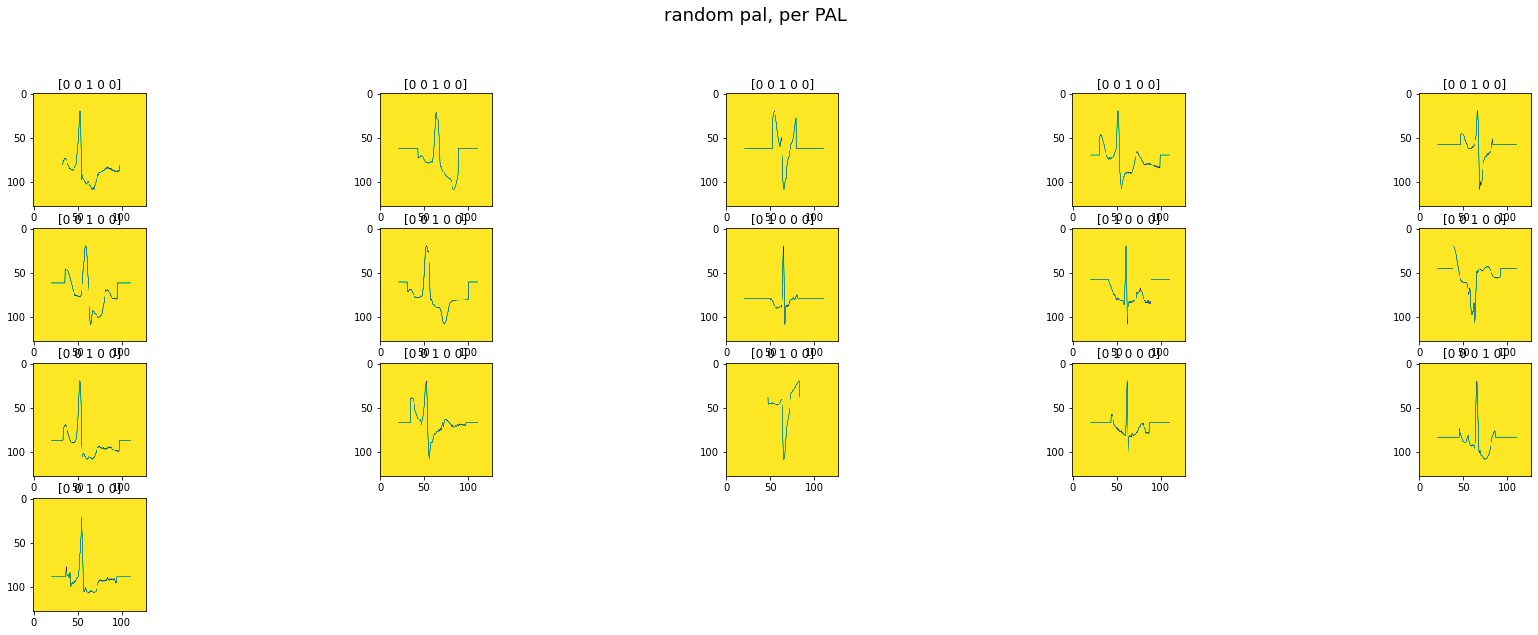

In [8]:
# 랜덤으로 뽑아서 뿌려보기

import matplotlib.pyplot as plt
import random
%matplotlib inline

plt.figure(figsize=(30, 12))
plt.suptitle("random pal, per PAL", fontsize=18)
n = 0
random.seed(11)
for i in random.sample(range(6480), 16):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(temp_converted_img[i] * 255.0, interpolation='nearest')
    ax.set_title(str(onehot_y[i]))
    n+=1

# 모델 생성

In [9]:
input_size = (128, 128, 1)

models = keras.Sequential([
    # tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_size),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),

    layers.Conv2D(128, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),

    layers.Conv2D(512, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [10]:
models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 256)      0

In [11]:
models.compile(
        optimizer='adam',
        # loss="sparse_categorical_crossentropy",
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

### 콜백 설정

In [12]:
# 콜백 설정
from keras.callbacks import EarlyStopping, ModelCheckpoint

outDir = './cheakpoint/lefms_model/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{val_accuracy:.4f}.h5'

def get_callbacks(patience = 50): 
    with tf.device('/gpu:0'):
        earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=patience)
        model_checkpoint = ModelCheckpoint(model_names, monitor='val_accuracy', verbose=1, save_best_only=True, period = 1)
    
        # callbacks = [earlystop, model_checkpoint]     # earlystop 사용하고 싶으면 이거 풀고 아래꺼 주석 처리
        callbacks = [model_checkpoint]
        return callbacks

# 학습하기

In [13]:
callbacks = get_callbacks()

with tf.device('/gpu:0'):
    models_hist = models.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCH,
        validation_data=(X_val, y_val),
        callbacks = [callbacks]
    )

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.6542
Epoch 1: val_accuracy improved from -inf to 0.65903, saving model to ./cheakpoint/lefms_model\weights-0.6590.h5
57/57 [==============================] - 22s 230ms/step - loss: 0.8906 - accuracy: 0.6542 - val_loss: 0.8355 - val_accuracy: 0.6590
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.6697
Epoch 2: val_accuracy did not improve from 0.65903
57/57 [==============================] - 10s 177ms/step - loss: 0.8176 - accuracy: 0.6697 - val_loss: 0.8235 - val_accuracy: 0.6590
Epoch 3/100
53/57 [==========================>...] - ETA: 0s - loss: 0.6267 - accuracy: 0.7515

# 결과 시각화 하기

In [ ]:
# 학습 된 모델의 학습 과정 시각화
import matplotlib.pyplot as plt
def plot_model__hist(hist):
    path = './cheakpoint/lefms/' # loss, accuracy 그래프 저장할 path
    createDirectory(path)

    # loss 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend()
    plt.show()

    # accuracy 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend(loc = "lower right")
    plt.show()

In [ ]:
plot_model__hist(models_hist)
loss,acc = models.evaluate((X_val, y_val), verbose=2)
print("multi_model의 정확도: {:5.2f}%".format(100*acc))
print("multi_model의 Loss: {}".format(loss))

# 모델 불러와서 confusion matrix 그리기

In [ ]:
# 모델 불러오기
reconstructed_model = keras.models.load_model("./cheakpoint/lefms_model/weights-1.0000.h5")

In [ ]:
# 예측값 얻기
y_pred = reconstructed_model.predict(X_test)

In [ ]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y= []
for val in y_test:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y.append(cnt)

In [ ]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y_pred = []
for val in y_pred:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y_pred.append(cnt)

In [ ]:
# 최종 정확도 산출
score = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])

### confusion matrix 그리기

In [ ]:
# 개수 버전
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

cm2 = confusion_matrix(new_y, new_y_pred)
sns.heatmap(cm2, annot = True, fmt = 'd', cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

In [ ]:
# percentile 버전
total = np.sum(cm2, axis=1)
cm2_percentile = cm2/total[:,None]
sns.heatmap(np.round(cm2_percentile,3), annot = True, cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y, new_y_pred)

In [ ]:
# classification_report 그리기
from sklearn.metrics import classification_report
target_names = ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q']
print(classification_report(new_y, new_y_pred, target_names=target_names))